In [472]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sys
import math
import sklearn
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

nltk.download('stopwords')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [473]:
df = pd.read_csv("datasets/cleaner_data.csv")
print(df.size)
df.head()

88767


,Unnamed: 0,name,multiverse_id,color_identity,text,flavor,power
0,1,Ancestor's Chosen,NaN,['W'],First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4
1,2,Angel of Mercy,129465.0,['W'],Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3
2,4,Angelic Blessing,129711.0,['W'],Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN
3,6,Angelic Chorus,129710.0,['W'],Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN
4,7,Angelic Wall,129671.0,['W'],Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0


In [474]:
def clean_color(text):
    # as cores são branco(W), preto(B), azul(U), vermelho(R) ou verde(G)
    pattern = r"\['(W|B|U|R|G)'\]"
    
    match = re.search(pattern, text)
    
    if match:
        return match.group(1)
    return None

df["color"] = df["color_identity"].apply(clean_color)
df.drop("color_identity", axis=1, inplace = True)

In [475]:
df["color"].value_counts()

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64

In [476]:
df.head()

,Unnamed: 0,name,multiverse_id,text,flavor,power,color
0,1,Ancestor's Chosen,NaN,First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4,W
1,2,Angel of Mercy,129465.0,Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3,W
2,4,Angelic Blessing,129711.0,Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN,W
3,6,Angelic Chorus,129710.0,Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN,W
4,7,Angelic Wall,129671.0,Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0,W


# STOP WORDS

In [477]:
def remove_reminder_text(text):
    if not isinstance(text, str):
        return ""  # alguns valores nulos, cartas sem texto de regra (costumam não ser muito jogadas mas existem)
    # Remove tudo o que está entre parentesis
    # São lembretes de regra para facilitar o jogo, mas que podem referir outras mecanicas diferentes e confundir 
    text_no_parentheses = re.sub(r'\(.*?\)', '', text)
    # Devolve o texto em lower case
    return text_no_parentheses.strip().lower()

In [478]:
def remove_punctuation(sentences):
    sentences_without_punctuation = [
        re.sub(r'[^a-zA-Zà-úÀ-Úâ-ûÂ-ÛãõÃÕáéíóúÁÉÍÓÚçÇüÜ ]+', '', sentence) for sentence in sentences
    ]
    return sentences_without_punctuation

In [479]:
def remove_non_letter_words(text):
    # split do texto
    words = text.split()
    # retira tudo que contém números e caracteres especiais (são sejam letras) e também retira palavras com letras repetidas (algumas onomatopéias como "aaaaahhhh")
    clean_words = [word for word in words if re.search(r'[a-zA-Z]', word)  and not re.search(r'(.)\1{2,}', word)] 
    return ' '.join(clean_words)

df['flavor'] = df['flavor'].apply(remove_non_letter_words)

In [480]:
print("\nColunas e valores únicos:")
for coluna in df.columns:
    print(f"\nColuna: {coluna}")
    print(df[coluna].unique())


Colunas e valores únicos:

Coluna: Unnamed: 0
[    1     2     4 ... 76228 76231 76232]

Coluna: name
["Ancestor's Chosen" 'Angel of Mercy' 'Angelic Blessing' ...
 'Vastwood Fortification // Vastwood Thicket' 'Veteran Adventurer'
 'Vine Gecko']

Coluna: multiverse_id
[    nan 129465. 129711. ... 491866. 491869. 491870.]

Coluna: text
["First strike (This creature deals combat damage before creatures without first strike.)\r\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."
 'Flying\r\nWhen Angel of Mercy enters the battlefield, you gain 3 life.'
 "Target creature gets +3/+3 and gains flying until end of turn. (It can't be blocked except by creatures with flying or reach.)"
 ... 'When Turntimber Ascetic enters the battlefield, you gain 3 life.'
 'Veteran Adventurer is also a Cleric, Rogue, Warrior, and Wizard.\r\nThis spell costs {1} less to cast for each creature in your party.\r\nVigilance'
 'The first kicked spell you cast each turn co

In [481]:
print(df.dtypes)

Unnamed: 0         int64
name              object
multiverse_id    float64
text              object
flavor            object
power             object
color             object
dtype: object


In [482]:
df['text'] = df['text'].fillna('')
df['all_Text'] = df['text'] + ' ' + df['flavor']
print(df[['text', 'flavor', 'all_Text']])

                                                    text  \
0      First strike (This creature deals combat damag...   
1      Flying\r\nWhen Angel of Mercy enters the battl...   
2      Target creature gets +3/+3 and gains flying un...   
3      Whenever a creature enters the battlefield und...   
4       Defender (This creature can't attack.)\r\nFlying   
...                                                  ...   
12676  Trample\r\nLandfall — Whenever a land enters t...   
12677  When Turntimber Ascetic enters the battlefield...   
12678            Put a +1/+1 counter on target creature.   
12679  Veteran Adventurer is also a Cleric, Rogue, Wa...   
12680  The first kicked spell you cast each turn cost...   

                                                  flavor  \
0                    "The will of all, by my hand done."   
1              Every tear shed is a drop of immortality.   
2      Only the warrior who can admit mortal weakness...   
3      The harmony of the glorious is a

In [483]:
df["flavor"] = df["flavor"].astype(str)  #meter os valores em str (algum poderia estar em numero, float, etc) - tendo em conta que flavor = object

#stop words tendo em conta a biblioteca NLTK (Natural Language Toolkit) English
stop_words = set(stopwords.words("english")) 

stop_words.update(["one", "never", "even", "every", "see"])  #stopwords que observamos durante a visualização dos dados que aparecia em todas as cores em grandes quantidades

In [484]:
def preprocess(text, stop_words): #fazemos o processamento de cada palavra de forma a ficar mais "pronta" para ser utilizada no processo de prever as cores
    #tirar as pontuações e meter tudo em minusculas
    text = re.sub(r'[^\w\s]', '', text.lower())  
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]#retirada de todas as stopwords
    return filtered_tokens

#df["processed_flavor"] = df["flavor"].apply(lambda x: preprocess(x, stop_words)) #um lambda para utilizar a função preprocess em cada frase da coluna "processed_flavor"
df["processed_flavor"] = df["all_Text"].apply(lambda x: preprocess(x, stop_words)) #um lambda para utilizar a função preprocess em cada frase da coluna "processed_flavor"

print(df["processed_flavor"])

0        [first, strike, creature, deals, combat, damag...
1        [flying, angel, mercy, enters, battlefield, ga...
2        [target, creature, gets, 33, gains, flying, en...
3        [whenever, creature, enters, battlefield, cont...
4        [defender, creature, cant, attack, flying, anc...
                               ...                        
12676    [trample, landfall, whenever, land, enters, ba...
12677    [turntimber, ascetic, enters, battlefield, gai...
12678    [put, 11, counter, target, creature, understan...
12679    [veteran, adventurer, also, cleric, rogue, war...
12680    [first, kicked, spell, cast, turn, costs, 1, l...
Name: processed_flavor, Length: 12681, dtype: object


# TF IDF testes

In [485]:
df['processed_flavor'] = df['processed_flavor'].apply(lambda x: ' '.join(x)) #como o processed flavor vinha numa lista 
#(por culpa do processamento de retirada de stop words), houve a necessidade de voltar a juntar as palavras numa frase para se processeder a realização do TF IDF

In [486]:
X = df #todos os dados, mas o que nos queremos será o processed_Flavor
y = df['color'] #cor

df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#inicialmente, para vermos como as previsões estão a funcionar, houve a necessidade de fazer tambem a tabela do TF IDF só com o dataset de treino de forma a
#ver realmente como se comporta a previsão do tf idf com novos dados
#se o tfidf tivesse utilizado os dados todos das cartas, nao tinhamos dados para testar as previsões
#posteriormente decidimos acrescentar o resto das cartas para ter o dataset de previsão final utilizado para prever cartas novas e as suas cores
#quando utilizamos o data set todo, e pegamos em cartas ja existentes, a previsão chega a 0.70% o que é natural porque a frase ja existe dentro da tabela, o que nos queremos
#é ver como se comporta com frases que a mesma nunca teve interação mas que ja teve interação com palavras de outras frases

In [487]:
#de forma a termos os documentos como as cores, tivemos de juntar todas as cores em uma cor unica, as, imaginemos, 300 linhas com cor azul, passa a ser 1 linha de cor azul com as varias palavras que essa cor conteve
df_grouped = df_train.groupby('color')['processed_flavor'].apply(lambda x: ' '.join(x)).reset_index()

#Iniciamos o TfidfVectorizer e ajustamos consoante os textos agrupados por cor
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_grouped['processed_flavor'])

#Pegar na matriz do TFIDF e passar para dataframe, de forma a tornar mais facil utilizar e vizualizar os dados
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_grouped['color']
)

In [488]:
#queria meter uma tabela de 1D onde so mostra o valor de tfidf com maior valor de uma cor e certa palavra
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ['color', 'word', 'tfidf']
#ordenar os dados para ver o Top 20 
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False).head(20)
print(top_tfidf_all)

      color      word     tfidf
3569      B  creature  0.565375
22910     G  creature  0.552712
80933     W  creature  0.538909
42251     R  creature  0.460744
61592     U  creature  0.399528
74766     U    target  0.379836
60452     U      card  0.358831
55425     R    target  0.350500
42485     R    damage  0.342897
16743     B    target  0.315792
94107     W    target  0.309389
56345     R      turn  0.307163
42611     R     deals  0.284353
2429      B      card  0.280456
80719     W   control  0.272681
95027     W      turn  0.263807
36084     G    target  0.262039
22696     G   control  0.252929
37004     G      turn  0.248590
9669      B      life  0.239540


In [489]:
#agora queriamos ver os valores dessas mesmas palavras mas para todas as cores

#As 20 palavras mais "importantes"
top_20_words = top_tfidf_all['word'].unique()
filtered_tfidf = tfidf_df[top_20_words]
top_20_tfidf = filtered_tfidf.loc[df['color'].unique()]
print(top_20_tfidf)

       creature    target      card    damage      turn     deals   control  \
color                                                                         
W      0.538909  0.309389  0.144408  0.148039  0.263807  0.039934  0.272681   
U      0.399528  0.379836  0.358831  0.034133  0.175039  0.028006  0.208297   
B      0.565375  0.315792  0.280456  0.085550  0.203089  0.055422  0.130929   
R      0.460744  0.350500  0.142177  0.342897  0.307163  0.284353  0.182853   
G      0.552712  0.262039  0.204772  0.088503  0.248590  0.044685  0.252929   

           life  
color            
W      0.149652  
U      0.021442  
B      0.239540  
R      0.024710  
G      0.095879  


In [490]:
#número máximo de linhas a serem exibidas
pd.set_option('display.max_rows', 1000)  

#tabela para o top 50 de cada cor
top_50_per_color = pd.DataFrame()
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False)

#top 50 palavras de cada cor
for color in tfidf_data['color'].unique():
    top_50_color = top_tfidf_all[top_tfidf_all['color'] == color].head(100)
    top_50_per_color = pd.concat([top_50_per_color, top_50_color])
    
print(top_50_per_color)


      color            word     tfidf
3569      B        creature  0.565375
16743     B          target  0.315792
2429      B            card  0.280456
9669      B            life  0.239540
17663     B            turn  0.203089
5180      B             end  0.164777
1437      B     battlefield  0.162173
12402     B          player  0.159198
9         B              11  0.137624
3570      B       creatures  0.136136
7133      B       graveyard  0.135764
3355      B         control  0.130929
2431      B           cards  0.122002
6773      B            gets  0.120886
14209     B       sacrifice  0.111959
7439      B            hand  0.103404
5270      B          enters  0.103032
11652     B        opponent  0.102288
4216      B         destroy  0.097081
6259      B          flying  0.090386
3803      B          damage  0.085550
9893      B           loses  0.072532
2486      B            cast  0.070672
6615      B            gain  0.069184
4387      B        discards  0.068605
3456      B 

In [491]:
#Reverter ao formato original de tfidf_df
pivot_tfidf = top_50_per_color.pivot(index='color', columns='word', values='tfidf')
#Preencher valores ausentes com 0 
pivot_tfidf = pivot_tfidf.fillna(0)
print(pivot_tfidf)

word         10        11       1b       1g       1r        1u       1w  \
color                                                                     
B      0.019342  0.137624  0.06635  0.00000  0.00000  0.000000  0.00000   
G      0.000000  0.200868  0.00000  0.06009  0.00000  0.000000  0.00000   
R      0.045238  0.072609  0.00000  0.00000  0.05425  0.000000  0.00000   
U      0.000000  0.059513  0.00000  0.00000  0.00000  0.057856  0.00000   
W      0.000000  0.172241  0.00000  0.00000  0.00000  0.000000  0.06095   

word         20        22        2b  ...   vampire  viashino  vigilance  \
color                                ...                                  
B      0.000000  0.043519  0.045274  ...  0.021109  0.000000   0.000000   
G      0.000000  0.054664  0.000000  ...  0.000000  0.000000   0.000000   
R      0.030032  0.020908  0.000000  ...  0.000000  0.018666   0.000000   
U      0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000   
W      0.000000  0.03872

In [492]:
#palavras a serem retiradas, a ideia é ver se existe palavras que tem a mesma importancia, ou parecida em todas as cores 
words_to_remove = []

for word in tfidf_df.columns:
    max_value = tfidf_df[word].max()
    intervalo = max_value / 4
    #calculamos o intervalor entre o max_value e os valores perto do mesmo, se nas outras cores a 
    #importancia tiver perto logo a palavra não é importante so para uma cor mas para varias, podendo nao ajudar na previsao das cores no futuro
    if all(tfidf_df[word].drop(index=tfidf_df[word].idxmax()) > max_value - intervalo): #excluimos o max_value da palavra atual durante a comparação
        words_to_remove.append(word)
# Remover as palavras identificadas
filtered_tfidf_df = tfidf_df.drop(columns=words_to_remove)

In [493]:
def remove_words(text, words_to_remove):
    #passar a palavras
    words = text.split()
    #remover as palavras que estão na lista 'words_to_remove'
    filtered_words = [word for word in words if word.lower() not in words_to_remove]
    #Junta as palavras restantes de volta em uma frase
    return ' '.join(filtered_words)
            
words_to_remove.append('color')
#para removermos as palavras anteriores tambem no proprio df
df_train['processed_flavor'] = df_train['processed_flavor'].apply(lambda x: remove_words(x, words_to_remove))
print("Palavras removidas:", words_to_remove)

Palavras removidas: ['abandoned', 'best', 'bottle', 'bug', 'callapheia', 'city', 'contained', 'content', 'designs', 'diamond', 'districts', 'far', 'gone', 'helping', 'keeping', 'laugh', 'list', 'permission', 'psemilla', 'send', 'shred', 'stickered', 'stops', 'strangers', 'think', 'wore', 'color']


In [494]:
all_words = []
for message in df['processed_flavor']:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 21682
Most common words: [('creature', 7852), ('target', 5029), ('turn', 3656), ('card', 3483), ('control', 3228), ('end', 2602), ('battlefield', 2493), ('creatures', 2356), ('damage', 2241), ('whenever', 1982), ('11', 1975), ('flying', 1837), ('player', 1802), ('may', 1789), ('enters', 1740)]


In [495]:
print(df['color'].value_counts())

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64


In [496]:
print(filtered_tfidf_df)

             00        01        02        03        04        05        0x  \
color                                                                         
B      0.000744  0.001860  0.001116  0.000000  0.000000  0.000000  0.000630   
G      0.001302  0.004338  0.002169  0.000000  0.001219  0.000735  0.000000   
R      0.001140  0.002661  0.001521  0.000000  0.000000  0.000000  0.000000   
U      0.003501  0.003501  0.001313  0.002964  0.000615  0.000000  0.000000   
W      0.000403  0.013311  0.006857  0.006147  0.002268  0.001366  0.000683   

             10      1010        11  ...       zur     zuran     zurdi  \
color                                ...                                 
B      0.019342  0.000000  0.137624  ...  0.000000  0.000000  0.000000   
G      0.007809  0.002731  0.200868  ...  0.000000  0.000000  0.001469   
R      0.045238  0.000000  0.072609  ...  0.000000  0.000000  0.000000   
U      0.010065  0.000000  0.059513  ...  0.004592  0.000918  0.000741   
W 

In [497]:
df_tfidf_prever = df_test.copy()

In [498]:
def calculate_color_score(tfidf_df, phrases): #previsão das cores tendo em conta os valores na tabela do tf idf
    #Todas as cores começam com 0 de pontuação
    color_scores = {color: 0 for color in tfidf_df.index}
    words = phrases.strip()  #Para nao termos espaços no início e fim das frases
    
    for word in words.split():  #Divide as palavras tendo em conta os espaços
        if word in tfidf_df.columns:
            for color in tfidf_df.index:
                #print('this is:', term, 'color',color,' pontuation:', tfidf_df.loc[color, term])  # Debug: verifique o termo completo
                color_scores[color] += tfidf_df.loc[color, word] #acrescenta a importancia de cada palavra a cor destinada a essa importancia
    #print(color_scores)
    #função sigmoide
    color_scores = {color: 1 / (1 + math.exp(-score)) for color, score in color_scores.items()}
    return color_scores

In [499]:
df_tfidf_prever['test_color'] = df_tfidf_prever['processed_flavor'].apply(lambda phrase: calculate_color_score(filtered_tfidf_df, phrase))
#vemos a a cor com a maior pontuação para cada frase
df_tfidf_prever['predicted_color'] = df_tfidf_prever['test_color'].apply(lambda x: max(x, key=x.get))
#Calcula a precisão ao comparar a cor real com a cor prevista
accuracy = accuracy_score(df_tfidf_prever['color'], df_tfidf_prever['predicted_color'])
print(f"Acc: {accuracy:.2f}")


Acc: 0.50


# Teste para utilizar NaiveBayes e Regressão Logistica

In [500]:
x_train_bow = features_bow
y_train = list(df_tfidf_prever['color'])  

#Remove a pontuação do texto
test_list = df_tfidf_prever['processed_flavor'].apply(remove_punctuation).tolist()

#características do BOW, TF-IDF
x_test_bow = vectorizer.transform(df_test).toarray()
x_test_tfidf = vectorizer_tfidf.transform(df_test).toarray()

y_test = list(df_tfidf_prever['color'])


In [501]:
#Naive Bayes
def classify_NaiveBayesian(x_train, y_train, x_test):
    nb = MultinomialNB()
    nb.fit(x_train, y_train)
    return nb.predict(x_test)

#regressão logistica
def classify_Logistic(x_train, y_train, x_test):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(x_train, y_train)
    return lr.predict(x_test)

#metodos de classificação
def collect_classification_metrics(y_test, y_test_predict, model_name, target_names):
    report = classification_report(y_test, y_test_predict, target_names=target_names, output_dict=True)
    accuracy = accuracy_score(y_test, y_test_predict)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    return report
    
#metricas de avaliação
def evaluation(y_pred, y_true, target_names):
    return classification_report(y_true, y_pred, target_names=target_names)



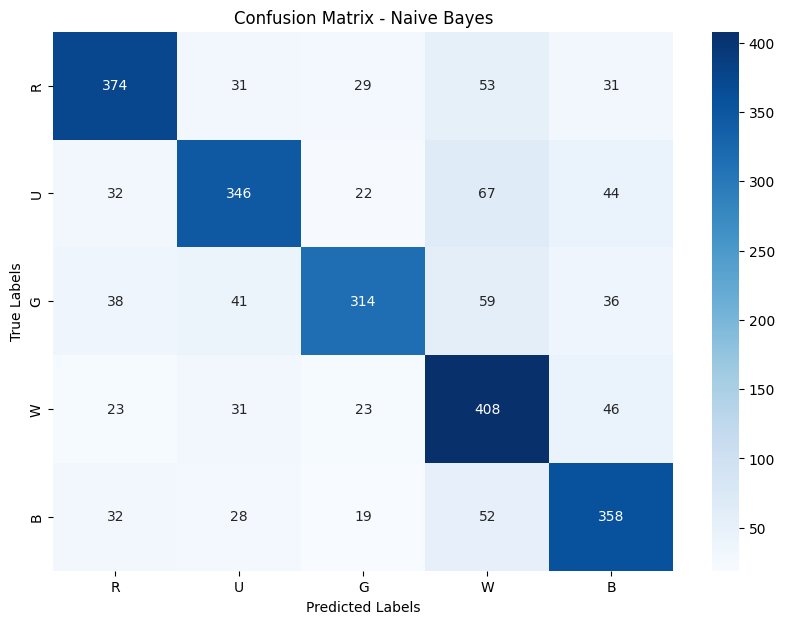

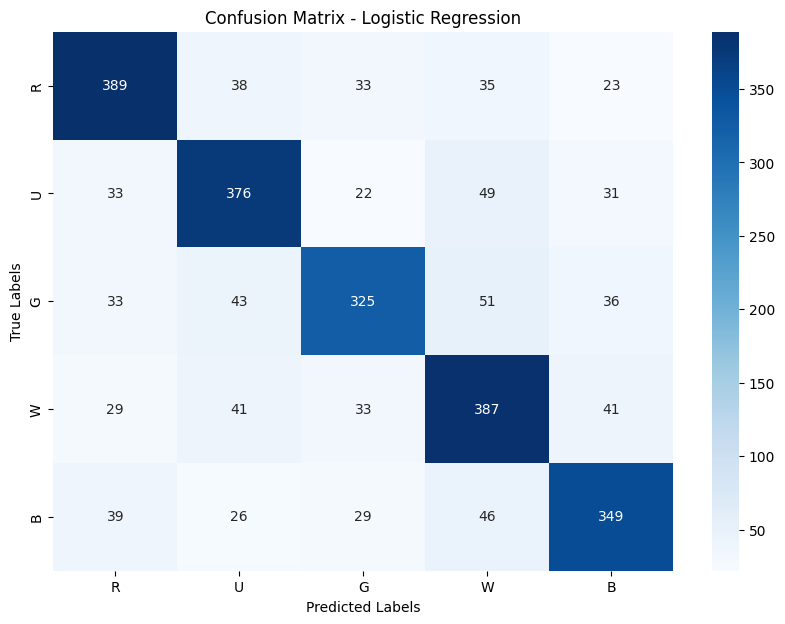

Model: TF-IDF + Naive Bayes
Accuracy: 0.71
Model: TF-IDF + Logistic Regression
Accuracy: 0.72

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           R       0.70      0.73      0.71       489
           U       0.77      0.64      0.70       488
           G       0.75      0.72      0.74       518
           W       0.73      0.68      0.70       511
           B       0.64      0.77      0.70       531

    accuracy                           0.71      2537
   macro avg       0.72      0.71      0.71      2537
weighted avg       0.72      0.71      0.71      2537


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           R       0.73      0.71      0.72       489
           U       0.74      0.67      0.70       488
           G       0.74      0.75      0.75       518
           W       0.72      0.74      0.73       511
           B       0.68      0.73      0.70       531

    accurac

In [502]:
train_texts = df_train['processed_flavor'].tolist() 
train_labels = df_train['color'].tolist() 

test_texts = df_test['processed_flavor'].tolist()  
test_labels = df_test['color'].tolist() 

#Vetorização dos textos com TF-IDF
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

x_train_count = vectorizer.fit_transform(train_texts)
x_train_tfidf = transformer.fit_transform(x_train_count)

x_test_count = vectorizer.transform(test_texts)
x_test_tfidf = transformer.transform(x_test_count)

#print(x_train_tfidf)
#print('_____________')
#print(train_labels)
#print('_____________')
#print(x_test_tfidf)
#print('_____________')

#Naive Bayes e Regressão Logística
y_test_predict_nb = classify_NaiveBayesian(x_train_tfidf, train_labels, x_test_tfidf)
y_test_predict_lr = classify_Logistic(x_train_tfidf, train_labels, x_test_tfidf)

target_names = ['R', 'U', 'G', 'W', 'B']  

#Calcular a Confusion Matrix para Naive Bayes
cm_nb = confusion_matrix(test_labels, y_test_predict_nb, labels=target_names)
#Calcular a Confusion Matrix para Regressão Logística
cm_lr = confusion_matrix(test_labels, y_test_predict_lr, labels=target_names)

#Confusion Matrix para Naive Bayes
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Confusion Matrix para Regressão Logística
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Métricas de classificação para Naive Bayes e Regressão Logística
metrics_bow_nb = collect_classification_metrics(test_labels, y_test_predict_nb, model_name="TF-IDF + Naive Bayes", target_names=target_names)
report_nb = evaluation(y_test_predict_nb, test_labels, target_names=target_names)

metrics_bow_lr = collect_classification_metrics(test_labels, y_test_predict_lr, model_name="TF-IDF + Logistic Regression", target_names=target_names)
report_lr = evaluation(y_test_predict_lr, test_labels, target_names=target_names)

print("\nNaive Bayes Classification Report:")
print(report_nb)

print("\nLogistic Regression Classification Report:")
print(report_lr)

In [503]:
#textos classificados incorretamente para Naive Bayes
incorrect_nb_texts = []
incorrect_nb_true_labels = []
incorrect_nb_pred_labels = []

for text, true_label, pred_label in zip(test_texts, test_labels, y_test_predict_nb):
    if true_label != pred_label:
        incorrect_nb_texts.append(text)
        incorrect_nb_true_labels.append(true_label)
        incorrect_nb_pred_labels.append(pred_label)

#DataFrame para os erros do Naive Bayes
incorrect_nb = pd.DataFrame({
    'Text': incorrect_nb_texts,
    'True Label': incorrect_nb_true_labels,
    'Predicted Label': incorrect_nb_pred_labels
})

#textos classificados incorretamente para Regressão Logística
incorrect_lr_texts = []
incorrect_lr_true_labels = []
incorrect_lr_pred_labels = []

for text, true_label, pred_label in zip(test_texts, test_labels, y_test_predict_lr):
    if true_label != pred_label:
        incorrect_lr_texts.append(text)
        incorrect_lr_true_labels.append(true_label)
        incorrect_lr_pred_labels.append(pred_label)

#DataFrame para os erros da Regressão Logística
incorrect_lr = pd.DataFrame({
    'Text': incorrect_lr_texts,
    'True Label': incorrect_lr_true_labels,
    'Predicted Label': incorrect_lr_pred_labels
})


print("\nTextos classificados incorretamente pelo Naive Bayes:")
print(incorrect_nb)

print("\nTextos classificados incorretamente pela Regressão Logística:")
print(incorrect_lr)


Textos classificados incorretamente pelo Naive Bayes:
                                                  Text True Label  \
0    whenever creature attacks planeswalker control...          W   
1    flying whenever cast kicked spell scry 2 gener...          U   
2    counter target colorless spell judges fair hel...          U   
3    additional cost cast spell sacrifice creature ...          U   
4    flash enchant creature enchanted creature gets...          U   
5    2g wily bandar gains indestructible end turn d...          G   
6    flash vigilance devour artifact 1 enters battl...          W   
7    heir ancient fang enters battlefield 11 counte...          G   
8    recruiter guard enters battlefield may search ...          W   
9    flash enchantment enters battlefield may put n...          U   
10   whenever crashing boars attacks defending play...          G   
11   4w creatures control get 11 end turn battlefie...          W   
12   hatching plans put graveyard battlefield dr

# REDE NEURONAL

In [504]:
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

#variáveis X e y
X = np.array([list(color.values()) for color in df_tfidf_prever['test_color']]) 
y = df_tfidf_prever['color']


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#one-hot encoding
y_one_hot = to_categorical(y_encoded)


X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
'''

"\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout\nfrom keras.utils import to_categorical\n\n#variáveis X e y\nX = np.array([list(color.values()) for color in df_tfidf_prever['test_color']]) \ny = df_tfidf_prever['color']\n\n\nlabel_encoder = LabelEncoder()\ny_encoded = label_encoder.fit_transform(y)\n\n#one-hot encoding\ny_one_hot = to_categorical(y_encoded)\n\n\nX_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)\n"

In [505]:
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import SGD 
# Criar o modelo
model = Sequential()

#128 neurônios e função de ativação 'relu'
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

# Camada oculta  1
model.add(Dense(64, activation='relu'))

# Camada oculta  2
model.add(Dense(32, activation='relu'))

#Dropout para prevenir overfitting
model.add(Dropout(0.2))

# Camada de saída com a função de ativação 'softmax' 
model.add(Dense(y_one_hot.shape[1], activation='softmax'))

# otimizador 'adam' e a função de perda 'categorical_crossentropy'
sgd_optimizer = SGD(learning_rate=0.01)  # Definindo a taxa de aprendizado do SGD
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()
'''

"\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout, Input\nfrom keras.utils import to_categorical\nfrom keras.optimizers import SGD \n# Criar o modelo\nmodel = Sequential()\n\n#128 neurônios e função de ativação 'relu'\nmodel.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))\n\n# Camada oculta  1\nmodel.add(Dense(64, activation='relu'))\n\n# Camada oculta  2\nmodel.add(Dense(32, activation='relu'))\n\n#Dropout para prevenir overfitting\nmodel.add(Dropout(0.2))\n\n# Camada de saída com a função de ativação 'softmax' \nmodel.add(Dense(y_one_hot.shape[1], activation='softmax'))\n\n# otimizador 'adam' e a função de perda 'categorical_crossentropy'\nsgd_optimizer = SGD(learning_rate=0.01)  # Definindo a taxa de aprendizado do SGD\nmodel.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics

In [506]:
'''
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))
'''

'\nhistory = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))\n'

In [507]:
'''
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acc no conjunto de teste: {accuracy:.4f}')
'''

"\nloss, accuracy = model.evaluate(X_test, y_test)\nprint(f'Acc no conjunto de teste: {accuracy:.4f}')\n"

In [508]:
'''
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
predicted_colors = label_encoder.inverse_transform(y_pred_classes)
print(f'Previsões: {predicted_colors}')
'''

"\ny_pred = model.predict(X_test)\ny_pred_classes = np.argmax(y_pred, axis=1)\npredicted_colors = label_encoder.inverse_transform(y_pred_classes)\nprint(f'Previsões: {predicted_colors}')\n"

# PREVISOES COM FEATURES

In [509]:
df_prever = df.copy()

In [510]:
df_prever.columns

Index(['Unnamed: 0', 'name', 'multiverse_id', 'text', 'flavor', 'power',
       'color', 'all_Text', 'processed_flavor'],
      dtype='object')

In [511]:
df_prever = df_prever.drop(columns=['Unnamed: 0', 'multiverse_id','text','flavor','processed_flavor','name'])

In [512]:
df_prever.isnull().sum()

power       5310
color          0
all_Text       0
dtype: int64

In [513]:
df_prever = df_prever.dropna() 

In [514]:
# Convertendo colunas booleanas em 0 e 1
boolean_columns = ['counterspell', 'exile', 'fight', 'mill', 'scry', 'tap', 'untap', 
                   'double_strike', 'first_strike', 'flash', 'flying', 'haste', 'hexproof', 
                   'indestructible', 'sacrifice', 'lifelink', 'menace', 'protection', 'prowess', 
                   'reach', 'trample', 'vigilance', 'draw', 'discard', 'damage', 'damage_prevention', 
                   'life_gain', 'life_loss', 'tokens', 'destroy', 'return', 'recursion']

# Convertendo as colunas booleanas para inteiros (0 ou 1)
df_prever[boolean_columns] = df_prever[boolean_columns].astype(int)

# Mapeando as cores para números
color_mapping = {
    'G': 1,  # Verde
    'R': 2,  # Vermelho
    'U': 3,  # Azul
    'W': 4,  # Branco
    'B': 5   # Preto
}

# Aplicando o mapeamento à coluna 'color'
df_prever['color'] = df_prever['color'].map(color_mapping)
# Caso a coluna 'color' tenha valores ausentes ou errados, podemos tratar com um valor padrão, por exemplo, 0
df_prever['color'] = df_prever['color'].fillna(0).astype(int)

# Tratando a coluna 'power' (convertendo para float, se necessário)
# Se a coluna 'power' contiver valores de texto como '*', podemos substituir por NaN antes da conversão
df_prever['power'] = pd.to_numeric(df_prever['power'], errors='coerce')

# Verificando o resultado
print(df_prever.head())

KeyError: "None of [Index(['counterspell', 'exile', 'fight', 'mill', 'scry', 'tap', 'untap',\n       'double_strike', 'first_strike', 'flash', 'flying', 'haste', 'hexproof',\n       'indestructible', 'sacrifice', 'lifelink', 'menace', 'protection',\n       'prowess', 'reach', 'trample', 'vigilance', 'draw', 'discard', 'damage',\n       'damage_prevention', 'life_gain', 'life_loss', 'tokens', 'destroy',\n       'return', 'recursion'],\n      dtype='object')] are in the [columns]"

In [ ]:
df_prever.columns

In [ ]:
print(df_prever.dtypes)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar colunas relevantes
selected_columns = ['color', 'counterspell', 'flying', 'haste', 'hexproof', 'indestructible', 
                    'lifelink', 'menace', 'protection', 'trample', 'vigilance', 'damage']

# Subset do DataFrame com as colunas selecionadas
df_selected = df_prever

# Calcular a matriz de correlação
correlation_matrix = df_selected.corr()

# Focar apenas nas correlações da variável `color` com as outras
color_correlation = correlation_matrix.loc[['color'], correlation_matrix.columns != 'color']

# Criar o heatmap
plt.figure(figsize=(20, 10))  # Tamanho ajustado para o gráfico horizontal
sns.heatmap(color_correlation, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, cbar_kws={'orientation': 'horizontal'})
plt.title('Correlação da Cor com Outras Variáveis', fontsize=14)
plt.xlabel('Variáveis')
plt.ylabel('Cor')
plt.show()



In [ ]:
df_prever_ml = df_prever[['exile', 'flying', 'lifelink', 'life_loss','color']]

In [ ]:
from sklearn.model_selection import train_test_split

X = df_prever_ml.drop('color', axis=1)  # Atributos
y = df_prever_ml['color']  # Alvo (cor da carta)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# WORLD CLOUD

In [ ]:
# Função para gerar o WordCloud para uma cor específica
def gerar_wordcloud_cor(cor, df):
    # Filtra as linhas onde a coluna 'color' contém a cor desejada
    filtered_words = df[df['color'].str.contains(cor, case=False, na=False)]['processed_flavor']

    # Cria uma string com todas as palavras filtradas
    comment_words = ' '.join(filtered_words)

    # Verifica se há palavras filtradas antes de gerar o WordCloud
    if comment_words:
        # Gerar o WordCloud com o texto filtrado
        wordcloud = WordCloud(width=800, height=800,
                              background_color='white',
                              stopwords=STOPWORDS,
                              min_font_size=10).generate(comment_words)

        # Exibe a imagem do WordCloud para a cor
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.tight_layout(pad=0)

        # Adiciona título com o nome da cor
        plt.title(f"WordCloud para a cor: {cor}", fontsize=16)
        plt.show()
    else:
        print(f"Não há palavras associadas à cor: {cor}")

# Escolha a cor desejada para o WordCloud
cor_escolhida = 'R'  # Exemplo: 'red', pode substituir por qualquer cor

# Chama a função para gerar o WordCloud para a cor escolhida
gerar_wordcloud_cor(cor_escolhida, df)
